# Progetto ICon 2023-2024

Nicola Mastromarino

Matricola 757709

# Analisi e Modellizzazione dei Dati di Malattie Cardiache

Quanto segue rappresenta un'analisi esaustiva di un dataset relativo alle malattie cardiache. L'obiettivo principale è quello di esplorare, preprocessare e modellare i dati per sviluppare un sistema predittivo accurato e interpretabile. 

## Obiettivi del Progetto

1. **Caricamento e Preprocessing dei Dati:** 
   - Caricamento dei dati grezzi e pulizia, inclusa la gestione dei valori mancanti e l'encoding delle variabili categoriali.
   - Divisione del dataset in variabili predittive (`X`) e target (`y`), con una descrizione dettagliata delle caratteristiche.

2. **Feature Engineering:**
   - Implementazione di tecniche avanzate di feature engineering, tra cui l'espansione polinomiale delle caratteristiche e la selezione automatizzata delle feature più rilevanti.
   - Visualizzazione e analisi delle correlazioni tra le variabili per identificare eventuali multicollinearità.

3. **Valutazione di Modelli di Machine Learning:**
   - Sperimentazione con diversi algoritmi di machine learning, tra cui Random Forest, K-Nearest Neighbors, Decision Tree, e XGBoost.
   - Utilizzo di tecniche di cross-validation per la valutazione delle prestazioni dei modelli.
   - Analisi della feature importance e interpretazione dei risultati per garantire che le decisioni del modello siano comprensibili e giustificabili.

4. **Clustering e Analisi delle Strutture Latenti:**
   - Applicazione di tecniche di clustering non supervisionato, come K-Means e DBSCAN, per scoprire pattern nascosti all'interno dei dati.
   - Utilizzo del Metodo del Gomito e altri strumenti per determinare il numero ottimale di cluster.

5. **Gestione dello Sbilanciamento dei Dati:**
   - Implementazione di tecniche di bilanciamento, come l'oversampling con SMOTE, per affrontare problemi di sbilanciamento delle classi nel dataset.

6. **Modellizzazione Bayesiana:**
   - Costruzione e inferenza di una rete bayesiana per comprendere meglio le relazioni probabilistiche tra le variabili.
   - Utilizzo della stima bayesiana e della variabile di eliminazione per la predizione e l'analisi diagnostica.

## Metodologia e Giustificazioni

Le scelte metodologiche sono motivate dall'obiettivo di bilanciare accuratezza predittiva e interpretabilità del modello, tenendo conto delle caratteristiche specifiche del dataset utilizzato. 


In [12]:
%matplotlib inline

In [13]:
# Importazioni standard
import os
import warnings
import joblib

# Importazioni di terze parti
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from xgboost import XGBClassifier
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianNetwork



# Configurazioni globali

# Percorso del file di dati
DATA_FILE_PATH = 'data/processed_cleveland.data'

# Impostazioni per la visualizzazione
FIGURE_SIZE = (12, 10)
CORRELATION_CMAP = 'coolwarm'  # Colormap utilizzata per la matrice di correlazione

# Parametri per il feature engineering
POLY_DEGREE = 2                # Grado di espansione polinomiale delle feature
N_FEATURES_TO_SELECT = 10       # Numero di feature da selezionare

# Impostazioni per il clustering
N_CLUSTERS = 3                  # Numero di cluster per l'algoritmo di clustering

# Seed per la riproducibilità
RANDOM_SEED = 42                # Seed per garantire la riproducibilità

def configure_environment():
    """
    Configura l'ambiente di esecuzione per garantire la riproducibilità e impostare le opzioni di visualizzazione.
    """
    # Impostazioni per la gestione delle librerie matematiche
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["KMP_INIT_AT_FORK"] = "FALSE"

    
    # Disabilita avvisi non critici
    warnings.filterwarnings("ignore", category=UserWarning)
    
    # Configurazione per le visualizzazioni con Seaborn
    sns.set(style='whitegrid', font_scale=1.2)
    
    # Risolve potenziali conflitti di librerie con KMP
    os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Chiamata alla funzione di configurazione
configure_environment()


## 1. Caricamento e Preprocessing dei Dati

Il primo passo nel nostro processo di analisi consiste nel caricare il dataset e applicare le operazioni di preprocessing necessarie per preparare i dati per la modellazione. Questo include la gestione dei valori mancanti, la codifica del target per classificazione binaria, e la divisione del dataset in variabili predittive (X) e target (y).



In [14]:


def load_and_preprocess_data(file_path):
    """
    Carica e preprocessa i dati dal file CSV specificato.

    Args:
        file_path (str): Il percorso del file CSV da caricare.

    Returns:
        pd.DataFrame: Il DataFrame preprocessato.
    """
    # Definizione dei nomi delle colonne in base alla documentazione del dataset
    column_names = [
        'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
    ]
    
    # Caricamento del dataset con la gestione dei valori mancanti indicati con '?'
    df = pd.read_csv(file_path, header=None, names=column_names, na_values='?')
    
    # Rimozione delle righe con valori mancanti
    df = df.dropna()
    
    # Codifica del target: 1 per presenza di malattia, 0 per assenza
    df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)
    
    return df

def preprocess_data(df):
    """
    Preprocessa i dati nel DataFrame fornito.

    Args:
        df (pd.DataFrame): Il DataFrame di input.

    Returns:
        tuple: X (features) e y (target) dopo il preprocessing.
    """
    # Separazione delle feature (X) dal target (y)
    X = df.drop('target', axis=1)
    y = df['target']
    
    return X, y


### Dettagli Implementativi

1. **Caricamento dei Dati:**
   - Il dataset viene caricato da un file CSV, con nomi di colonne assegnati manualmente in base alla documentazione del dataset.
   - I valori mancanti, indicati come `'?'`, vengono convertiti in `NaN` durante la lettura del file e successivamente rimossi con `df.dropna()`. Questo assicura che i modelli non ricevano input incompleti.

2. **Codifica del Target:**
   - Il target originale viene convertito in una variabile binaria (`0` per l'assenza di malattia e `1` per la presenza). Questo è un passaggio cruciale per trasformare il problema in una classificazione binaria.

3. **Separazione delle Variabili:**
   - Le variabili predittive (`X`) sono separate dalla variabile target (`y`) per essere pronte all'uso nei modelli di machine learning.

Questa fase di preprocessing è fondamentale per garantire la qualità dei dati che alimenteranno i modelli di machine learning. La gestione dei valori mancanti e la corretta codifica del target sono passaggi necessari per evitare bias e garantire risultati accurati e affidabili.



## 2. Feature Engineering

Il feature engineering è un passo cruciale nell'analisi dei dati, poiché permette di trasformare e creare nuove variabili (feature) che possono migliorare significativamente le prestazioni dei modelli di machine learning. Nel contesto di questo progetto, applichiamo le seguenti tecniche di feature engineering:

1. **Standardizzazione delle Feature:**
   - Prima di addestrare i modelli, è importante standardizzare le variabili predittive per assicurarsi che tutte abbiano una scala comune. Questo processo, noto come standardizzazione, converte le feature affinché abbiano media pari a 0 e deviazione standard pari a 1. Questo è particolarmente utile per modelli che sono sensibili alla scala delle variabili, come quelli basati su distanza (ad esempio, K-Nearest Neighbors). Nel codice, questa operazione viene eseguita utilizzando `StandardScaler`.

2. **Creazione di Feature Polinomiali:**
   - Le feature polinomiali sono create combinando le feature originali fino al secondo grado. Questo consente di catturare relazioni non lineari tra le variabili, che potrebbero essere rilevanti per migliorare la capacità predittiva dei modelli. Ad esempio, il prodotto di due feature originali può rivelare interazioni che i modelli lineari semplici non riuscirebbero a cogliere. Nel codice, questo viene implementato tramite `PolynomialFeatures` con `degree=2`.

3. **Selezione delle Feature:**
   - Dopo aver generato un numero potenzialmente elevato di feature polinomiali, è essenziale ridurre la dimensionalità del dataset selezionando solo le feature più rilevanti. Questo passaggio viene eseguito utilizzando il metodo Recursive Feature Elimination (RFE) con un modello di Random Forest come estimatore. L'obiettivo è migliorare l'efficienza dei modelli, ridurre il rischio di overfitting, e mantenere solo le variabili che contribuiscono maggiormente alle previsioni. Nel codice, selezioniamo le 10 feature più importanti.

Queste tecniche di feature engineering non solo preparano i dati per l'addestramento, ma contribuiscono anche a migliorare le prestazioni e l'interpretabilità dei modelli di machine learning sviluppati in questo progetto.

In [15]:

def perform_feature_engineering(df):
    """
    Esegue il feature engineering sul DataFrame fornito.

    Args:
        df (pd.DataFrame): Il DataFrame di input.

    Returns:
        tuple: X (features) e y (target) dopo il feature engineering.
    """
    X = df.drop('target', axis=1)
    y = df['target']

    # Standardizzazione
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Feature polinomiali
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X_scaled)

    # Selezione delle feature
    rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
    X_selected = rfe.fit_transform(X_poly, y)

    return X_selected, y

## 3. Valutazione dei Modelli di Machine Learning

In questa sezione, valutiamo le prestazioni di diversi modelli di machine learning utilizzando tecniche avanzate di validazione incrociata (cross-validation) e metriche di valutazione. I modelli considerati includono Random Forest, K-Nearest Neighbors, Decision Tree, XGBoost e Naive Bayes. L'obiettivo è identificare il modello più performante e ottimizzare i suoi iperparametri per migliorare ulteriormente le sue prestazioni.

### Valutazione del Modello

La funzione `evaluate_model` è responsabile della valutazione di un singolo modello. Il processo include:

- **Cross-Validation:** Viene utilizzata la stratificazione dei dati con `StratifiedKFold` per mantenere la distribuzione delle classi in ciascuna suddivisione, e vengono calcolati i punteggi di accuratezza per ogni suddivisione.
- **Divisione Train/Test:** Il dataset viene diviso in un set di addestramento e uno di test per validare le prestazioni del modello su dati non visti.
- **Matrice di Confusione:** Viene generata e visualizzata una matrice di confusione per esaminare in dettaglio le prestazioni del modello in termini di classificazione corretta e errata.
- **Curva ROC:** Viene tracciata la curva ROC e calcolata l'area sotto la curva (AUC) per valutare la capacità del modello di distinguere tra le classi.
- **Importanza delle Feature:** Se il modello lo supporta, viene visualizzata l'importanza delle feature per interpretare quali variabili sono maggiormente influenti nelle decisioni del modello.

### Valutazione di Modelli Multipli

La funzione `evaluate_models` esegue la valutazione di diversi modelli sullo stesso dataset:

- **Modelli Considerati:** Random Forest, K-Nearest Neighbors, XGBoost, Decision Tree e Naive Bayes.
- **Pipeline di Preprocessing:** Ogni modello è inserito in una pipeline che include la standardizzazione delle feature.
- **Ottimizzazione degli Iperparametri:** Per modelli come Random Forest, K-Nearest Neighbors, XGBoost e Decision Tree, utilizziamo `GridSearchCV` per ottimizzare gli iperparametri e migliorare le prestazioni del modello.
- **Curve di Apprendimento:** Vengono tracciate le curve di apprendimento per ogni modello per visualizzare come le prestazioni del modello migliorano man mano che viene addestrato con più dati.
- **Salvataggio dei Modelli:** Dopo la valutazione, i modelli vengono salvati in una directory specificata per un uso futuro.

### Ottimizzazione dei Modelli

La funzione `optimize_model` si occupa dell'ottimizzazione degli iperparametri dei modelli tramite `GridSearchCV`:

- **Grid Search:** Vengono esplorate diverse combinazioni di iperparametri per identificare la configurazione che massimizza l'accuratezza del modello.
- **Cross-Validation Ottimizzata:** La ricerca dei parametri ottimali avviene utilizzando una cross-validation stratificata per garantire che la selezione dei parametri migliori sia robusta e generalizzabile.

### Creazione della Pipeline

La funzione `create_ml_pipeline` permette di creare una pipeline di machine learning che include sia il preprocessing (standardizzazione) sia il modello specificato. Questa pipeline facilita l'integrazione di vari passaggi in un unico flusso di lavoro, semplificando la valutazione e l'ottimizzazione del modello.

In [16]:
# Valutazione dei modelli di machine learning

def evaluate_model(model, X, y):
    """
    Valuta un modello utilizzando cross-validation e fornisce un report dettagliato.

    Args:
        model: Il modello da valutare.
        X: Le feature.
        y: Il target.
    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"Cross-validation scores: {scores}")
    print(f"Mean CV score (Accuracy): {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.3f}")

    # Matrice di confusione
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice di Confusione')
    plt.ylabel('Valore Reale')
    plt.xlabel('Valore Predetto')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # ROC Curve
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_imp = pd.DataFrame(sorted(zip(importances, X.columns)), columns=['Value', 'Feature'])
        plt.figure(figsize=(10, 8))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
        plt.title('Feature Importances')
        plt.tight_layout()
        plt.show()

    return model



def evaluate_models(X, y, save_dir='../saved_models'):
    """
    Valuta diversi modelli sullo stesso dataset e salva i modelli in una cartella specificata.

    Args:
        X: Le feature.
        y: Il target.
        save_dir: La directory in cui salvare i modelli.
    """
    # Crea la cartella se non esiste
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    models = {
        "Random Forest": RandomForestClassifier(random_state=42),
        "k-NN": KNeighborsClassifier(),
        "XGBoost": XGBClassifier(random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Naive Bayes": GaussianNB()  # Aggiunto Naive Bayes
    }

    param_grids = {
        "Random Forest": {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20]},
        "k-NN": {'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance']},
        "XGBoost": {'model__n_estimators': [100, 200], 'model__max_depth': [3, 5, 7]},
        "Decision Tree": {'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5, 10]},
        "Naive Bayes": {}  # Naive Bayes non ha iperparametri da ottimizzare in questo caso
    }

    for name, model in models.items():
        print(f"\n{name} Baseline:")
        pipeline = create_ml_pipeline(model)
        evaluate_model(pipeline, X, y)

        if name != "Naive Bayes":
            print(f"\n{name} Optimized:")
            best_model = optimize_model(pipeline, param_grids[name], X, y)
            evaluate_model(best_model, X, y)
        else:
            print("\nNaive Bayes non richiede ottimizzazione degli iperparametri.")

        # Learning Curve
        plot_learning_curve(pipeline, f'Learning Curve for {name}', X, y, ylim=(0.7, 1.01), cv=5, n_jobs=4)
        plt.show()

        # Save the model
        model_filename = os.path.join(save_dir, f"{name.lower().replace(' ', '_')}_model.joblib")
        joblib.dump(pipeline, model_filename)


def optimize_model(model, param_grid, X, y):
    """
Ottimizza un modello utilizzando GridSearchCV.

Args:
    model: Il modello da ottimizzare.
    param_grid: I parametri da testare.
    X: Le feature.
    y: Il target.

Returns:
    Il modello ottimizzato.

    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    return grid_search.best_estimator_


def create_ml_pipeline(model):
    """
    Crea un pipeline per il modello.
    :param model:
    :return:
    """
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])



## 4. Metodo del Gomito

Il metodo del gomito è una tecnica utilizzata per determinare il numero ottimale di cluster in un dataset quando si utilizza l'algoritmo di clustering K-Means. Questo metodo si basa sull'analisi della somma delle distanze quadratiche all'interno dei cluster (WCSS - Within-Cluster Sum of Squares) per diversi numeri di cluster.

### Implementazione del Metodo del Gomito

La funzione `plot_elbow_curve` esegue i seguenti passaggi:

1. **Calcolo del WCSS:** Per ciascun numero di cluster da 1 a 10, viene eseguito l'algoritmo K-Means sul dataset `X`. Il WCSS è calcolato per ogni configurazione, ed è una misura della compattezza dei cluster (più basso è il WCSS, più vicini sono i punti all'interno dei cluster).

2. **Tracciamento della Curva:** Il WCSS per ciascun numero di cluster viene memorizzato e tracciato su un grafico. Sull'asse x viene riportato il numero di cluster, mentre sull'asse y viene riportato il valore di WCSS.

3. **Identificazione del "Gomito":** Il "gomito" nel grafico, cioè il punto in cui la diminuzione del WCSS inizia a rallentare, indica il numero ottimale di cluster. Questo punto rappresenta un buon equilibrio tra il numero di cluster e la compattezza dei gruppi.

In [17]:
# Metodo del gomito
def plot_elbow_curve(X):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=RANDOM_SEED, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    plt.figure(figsize=FIGURE_SIZE)
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Metodo del Gomito')
    plt.xlabel('Numero di Cluster')
    plt.ylabel('WCSS')
    plt.show()

### Interpretazione del Grafico

Il grafico risultante mostrerà una curva decrescente che tende a livellarsi man mano che aumenta il numero di cluster. Il punto in cui si osserva un evidente cambio di pendenza, che assomiglia a un gomito, suggerisce il numero di cluster ideale da utilizzare per l'analisi. Questo approccio è molto utile quando si cerca di determinare un numero ragionevole di cluster senza introdurre troppi o troppo pochi gruppi nel modello.

## 5. Gestione dello Sbilanciamento

Nell'analisi dei dati, lo sbilanciamento delle classi rappresenta una sfida significativa, specialmente quando una classe è molto più rappresentata rispetto all'altra. Questo può portare a modelli di machine learning che hanno prestazioni scarse nel riconoscere la classe minoritaria. Per affrontare questo problema, utilizziamo la tecnica SMOTE (Synthetic Minority Over-sampling Technique) combinata con un modello di Random Forest.

### Implementazione della Gestione dello Sbilanciamento

La funzione `handle_imbalance` implementa un flusso di lavoro completo per gestire lo sbilanciamento delle classi, comprendente i seguenti passaggi:

1. **Pipeline con SMOTE e Random Forest:**
   - Una pipeline viene creata utilizzando `ImbPipeline` che include la standardizzazione delle feature, l'applicazione di SMOTE per bilanciare le classi, e l'addestramento di un modello di Random Forest.
   - SMOTE genera campioni sintetici della classe minoritaria per bilanciare il dataset, migliorando così la capacità del modello di riconoscere entrambe le classi.

2. **Valutazione del Modello:**
   - Il modello Random Forest con SMOTE viene valutato utilizzando la funzione `evaluate_model`, che misura le prestazioni del modello in termini di accuratezza, matrice di confusione, curva ROC, e altro.

3. **Visualizzazione della Distribuzione delle Classi:**
   - Prima di applicare SMOTE, la distribuzione delle classi nel dataset originale viene visualizzata per evidenziare lo sbilanciamento.
   - Dopo l'applicazione di SMOTE, la nuova distribuzione delle classi viene visualizzata per mostrare come SMOTE ha bilanciato le classi.

4. **Confronto delle Distribuzioni:**
   - La funzione stampa e confronta la distribuzione delle classi prima e dopo l'applicazione di SMOTE, evidenziando l'efficacia della tecnica nell'equilibrare il dataset.

In [18]:
# Gestione dello sbilanciamento
def handle_imbalance(X, y):
    smote_pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', RandomForestClassifier(random_state=42))
    ])
    print("\nRandom Forest with SMOTE:")
    evaluate_model(smote_pipeline, X, y)

    # Visualizza la distribuzione delle classi prima di SMOTE
    class_counts_before = y.value_counts().sort_index().tolist()
    plot_class_distribution(y)
    plot_class_distribution_bar(y)

    # Applica SMOTE e visualizza la nuova distribuzione delle classi
    X_res, y_res = smote_pipeline.named_steps['smote'].fit_resample(X, y)
    class_counts_after = pd.Series(y_res).value_counts().sort_index().tolist()
    plot_class_distribution_after_smote(pd.Series(y_res))
    plot_class_distribution_bar_after_smote(pd.Series(y_res))

    # Stampa i dati per il grafico di confronto
    print("\nDati per il grafico di confronto SMOTE:")
    print("Prima di SMOTE:", class_counts_before)
    print("Dopo SMOTE:", class_counts_after)

    return X_res, y_res
    

### Importanza della Gestione dello Sbilanciamento

Affrontare lo sbilanciamento delle classi è cruciale per garantire che i modelli di machine learning non siano prevenuti verso la classe maggioritaria. Utilizzando SMOTE, possiamo migliorare la capacità del modello di riconoscere e classificare correttamente la classe minoritaria, aumentando così la sua efficacia generale e rendendo il modello più affidabile in applicazioni reali.


## 6. Clustering e Visualizzazione

In questa sezione, eseguiamo tecniche di clustering utilizzando gli algoritmi K-Means e DBSCAN per identificare gruppi (cluster) all'interno del dataset. Successivamente, visualizziamo i risultati del clustering utilizzando la PCA (Principal Component Analysis) per ridurre la dimensionalità dei dati e rendere i risultati più interpretabili. Inoltre, visualizziamo le correlazioni tra le feature per comprendere meglio le relazioni all'interno del dataset.

### 1. Clustering con K-Means e DBSCAN

La funzione `perform_clustering` esegue il clustering su un dataset normalizzato (`X_scaled`) utilizzando due algoritmi:

- **K-Means:** Un algoritmo di clustering che suddivide il dataset in un numero predefinito di cluster (in questo caso 3). I punti all'interno di ciascun cluster sono più simili tra loro rispetto ai punti di altri cluster.
- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise):** Un algoritmo di clustering che identifica cluster di qualsiasi forma, basandosi sulla densità locale di punti, ed è efficace nel rilevare rumore e outlier.

I risultati del clustering vengono quindi visualizzati in due grafici affiancati dopo l'applicazione della PCA per ridurre i dati a due dimensioni.

### 2. Visualizzazione delle Correlazioni tra le Feature

La funzione `visualize_correlations` genera una heatmap delle correlazioni tra le feature del dataset. Questa visualizzazione aiuta a identificare quali feature sono fortemente correlate tra loro, il che può essere utile per comprendere la struttura dei dati e potenzialmente per ridurre la dimensionalità.

### 3. Curve di Apprendimento

La funzione `plot_learning_curve` viene utilizzata per tracciare le curve di apprendimento del modello. Questi grafici mostrano come la performance del modello cambia in funzione della quantità di dati di addestramento utilizzati. Sono utili per diagnosticare problemi come l'overfitting o l'underfitting.

### 4. Visualizzazione della Distribuzione delle Classi

Diverse funzioni sono fornite per visualizzare la distribuzione delle classi sia prima che dopo l'applicazione di SMOTE, utilizzando grafici a torta e a barre:

- **plot_class_distribution:** Mostra la distribuzione originale delle classi nel dataset.
- **plot_class_distribution_bar:** Visualizza la distribuzione delle classi originali utilizzando un grafico a barre.
- **plot_class_distribution_after_smote:** Mostra la distribuzione delle classi dopo l'applicazione di SMOTE per bilanciare il dataset.
- **plot_class_distribution_bar_after_smote:** Visualizza la distribuzione delle classi bilanciate (dopo SMOTE) con un grafico a barre.

In [19]:

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    :param estimator:
    :param title:
    :param X:
    :param y:
    :param ylim:
    :param cv:
    :param n_jobs:
    :param train_sizes:
    :return:
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def visualize_correlations(df):
    """
    Visualizza le correlazioni tra le feature.
    :param df:
    :return:
    """
    corr = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Correlations')
    plt.show()


def perform_clustering(X_scaled):
    """
    Esegue il clustering utilizzando K-means e DBSCAN.
    :param X_scaled:
    :return:

    """
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled)

    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    fig = make_subplots(rows=1, cols=2, subplot_titles=('K-means Clustering', 'DBSCAN Clustering'))

    fig.add_trace(
        go.Scatter(x=X_pca[:, 0], y=X_pca[:, 1], mode='markers',
                   marker=dict(color=kmeans_labels, colorscale='Viridis')),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=X_pca[:, 0], y=X_pca[:, 1], mode='markers',
                   marker=dict(color=dbscan_labels, colorscale='Viridis')),
        row=1, col=2
    )

    fig.update_layout(height=600, width=1200, title_text="Clustering Results")
    fig.show()
    
# Grafico a torta per visualizzare la distribuzione delle classi
def plot_class_distribution(y):
    """
    Visualizza la distribuzione delle classi.
    :param y:
    :return:
    """
    class_counts = y.value_counts()
    fig = go.Figure(data=[go.Pie(labels=class_counts.index, values=class_counts.values)])
    fig.update_layout(title_text='Class Distribution')
    fig.show()
    
# Grafico a barre per visualizzare la distribuzione delle classi
def plot_class_distribution_bar(y):
    """
    Visualizza la distribuzione delle classi.
    :param y:
    :return:
    """
    class_counts = y.value_counts()
    fig = go.Figure(data=[go.Bar(x=class_counts.index, y=class_counts.values)])
    fig.update_layout(title_text='Class Distribution')
    fig.show()

# Grafico dopo SMOTE per visualizzare la distribuzione delle classi
def plot_class_distribution_after_smote(y_resampled):
    """
    Visualizza la distribuzione delle classi dopo l'applicazione di SMOTE.
    :param y_resampled:
    :return:
    """
    class_counts = y_resampled.value_counts()
    fig = go.Figure(data=[go.Pie(labels=class_counts.index, values=class_counts.values)])
    fig.update_layout(title_text='Class Distribution After SMOTE')
    fig.show()
    
# Grafico a barre per visualizzare la distribuzione delle classi dopo SMOTE
def plot_class_distribution_bar_after_smote(y_resampled):
    """
    Visualizza la distribuzione delle classi dopo l'applicazione di SMOTE.
    :param y_resampled:
    :return:
    """
    class_counts = y_resampled.value_counts()
    fig = go.Figure(data=[go.Bar(x=class_counts.index, y=class_counts.values)])
    fig.update_layout(title_text='Class Distribution After SMOTE')
    fig.show()


## 7. Modello Ensemble

In questa sezione, costruiamo e valutiamo un modello ensemble, che combina le previsioni di diversi algoritmi di machine learning per migliorare la robustezza e l'accuratezza delle previsioni. Il modello ensemble utilizza una combinazione di Random Forest, K-Nearest Neighbors (KNN) e XGBoost, implementato attraverso un `VotingClassifier`.

### Implementazione del Modello Ensemble

La funzione `create_ensemble_model` esegue i seguenti passaggi:

1. **Creazione dei Modelli Base:**
   - **Random Forest (`rf`):** Un modello basato su alberi decisionali che crea una "foresta" di alberi per migliorare la capacità predittiva e ridurre il rischio di overfitting.
   - **K-Nearest Neighbors (`knn`):** Un algoritmo basato su distanza che classifica un dato punto in base alla maggioranza dei suoi vicini più prossimi.
   - **XGBoost (`xgb`):** Un potente modello basato su boosting che crea una serie di alberi decisionali in sequenza, migliorando iterativamente la precisione delle previsioni.

2. **Creazione del Voting Classifier:**
   - Utilizziamo un `VotingClassifier` per combinare i tre modelli base. Il tipo di voting scelto è "soft", il che significa che le probabilità previste dai singoli modelli vengono mediate per produrre la previsione finale.

3. **Creazione della Pipeline:**
   - Il modello ensemble è inserito in una pipeline che include la standardizzazione delle feature tramite `StandardScaler`. Questo assicura che tutte le feature siano su scala simile, migliorando le prestazioni del KNN e di altri modelli basati su distanza.

4. **Valutazione del Modello Ensemble:**
   - La pipeline completa viene valutata utilizzando la funzione `evaluate_model`, che fornisce un'analisi dettagliata delle prestazioni del modello su un set di dati di test, includendo metriche come l'accuratezza, la matrice di confusione, la curva ROC, e altro.

In [20]:


def create_ensemble_model(X, y):
    """
    Crea e valuta un modello ensemble.

    Args:
        X: Le feature.
        y: Il target.
    """

    rf = RandomForestClassifier(random_state=42)
    knn = KNeighborsClassifier()
    xgb = XGBClassifier(random_state=42)

    ensemble = VotingClassifier(
        estimators=[('rf', rf), ('knn', knn), ('xgb', xgb)],
        voting='soft'
    )

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ensemble', ensemble)
    ])

    print("\nEnsemble Model:")
    evaluate_model(pipeline, X, y)


### Vantaggi del Modello Ensemble

L'approccio ensemble offre diversi vantaggi:

- **Robustezza:** Combinando più modelli, il sistema è meno suscettibile agli errori di un singolo modello.
- **Accuratezza Migliorata:** Il voting soft può migliorare l'accuratezza predittiva aggregando le previsioni probabilistiche di ciascun modello.
- **Bilanciamento dei Pregi di Ogni Modello:** Ogni algoritmo contribuisce con i propri punti di forza, migliorando la performance generale del modello ensemble.

## 8. Analisi con Rete Bayesiana

Le reti bayesiane sono potenti strumenti probabilistici utilizzati per modellare le relazioni tra variabili all'interno di un dataset. In questa sezione, utilizziamo una rete bayesiana per analizzare le relazioni tra le variabili del dataset e per eseguire inferenze basate su evidenze specifiche. Questo tipo di analisi è utile per comprendere meglio le dipendenze condizionali tra le variabili e per effettuare previsioni basate su nuove osservazioni.

### Implementazione della Rete Bayesiana

La funzione `create_bayesian_network` esegue i seguenti passaggi:

1. **Definizione della Struttura della Rete:**
   - La struttura della rete bayesiana viene definita manualmente specificando le dipendenze tra le variabili. In questo esempio, `age` e `sex` influenzano i livelli di colesterolo (`chol`) e la pressione sanguigna a riposo (`trestbps`), mentre sia `chol` che `trestbps` influenzano la variabile target che indica la presenza di malattia cardiaca.

2. **Apprendimento dei Parametri della Rete:**
   - Dopo aver definito la struttura, i parametri della rete (probabilità condizionali) vengono appresi dai dati utilizzando l'estimatore bayesiano (`BayesianEstimator`). L'opzione `prior_type="BDeu"` specifica il tipo di priore utilizzato nell'apprendimento.

### Inferenza con la Rete Bayesiana

La funzione `perform_inference` consente di eseguire inferenze sulla rete bayesiana:

- **Evidenza:** L'utente fornisce un insieme di evidenze (valori noti per alcune variabili), e la rete bayesiana calcola la probabilità di diverse condizioni target, date queste evidenze. 
- **Inferenza:** In questo caso, si utilizza l'eliminazione delle variabili (`VariableElimination`) per eseguire l'inferenza e calcolare la probabilità della malattia cardiaca dato un set di evidenze specifico.

### Analisi Completa con la Rete Bayesiana

La funzione `bayesian_network_analysis` combina la creazione della rete bayesiana e l'inferenza:

1. **Creazione della Rete Bayesiana:**
   - Viene creata una rete bayesiana utilizzando il dataset fornito.
   
2. **Esecuzione dell'Inferenza:**
   - Viene eseguita un'inferenza utilizzando un set di evidenze specifico, come l'età di 60 anni, sesso maschile, colesterolo di 240 mg/dl, e una pressione sanguigna a riposo di 140 mmHg.

3. **Visualizzazione dei Risultati:**
   - Viene stampata la probabilità di avere una malattia cardiaca dato il set di evidenze fornito.

In [21]:

def create_bayesian_network(df):
    """
    Crea una rete bayesiana dal DataFrame fornito.

    Args:
        df (pd.DataFrame): Il DataFrame di input.

    Returns:
        BayesianNetwork: La rete bayesiana creata.
    """
    model = BayesianNetwork([('age', 'chol'), ('age', 'trestbps'),
                             ('sex', 'chol'), ('sex', 'trestbps'),
                             ('chol', 'target'), ('trestbps', 'target')])
    model.fit(df, estimator=BayesianEstimator, prior_type="BDeu")
    return model


def perform_inference(model, evidence):
    """
    Esegue l'inferenza sulla rete bayesiana.

    Args:
        model (BayesianNetwork): La rete bayesiana.
        evidence (dict): Le evidenze per l'inferenza.

    Returns:
        VariableElimination: Il risultato dell'inferenza.
    """
    inference = VariableElimination(model)
    return inference.query(['target'], evidence=evidence)


def bayesian_network_analysis(df):
    """
    Esegue l'analisi con la rete bayesiana.

    Args:
        df (pd.DataFrame): Il DataFrame di input.
    """
    model = create_bayesian_network(df)
    evidence = {'age': 60, 'sex': 1, 'chol': 240, 'trestbps': 140}
    result = perform_inference(model, evidence)
    print("Probabilità di malattia cardiaca dato l'evidence:")
    print(result)


### Applicazione della Rete Bayesiana

Le reti bayesiane sono particolarmente utili in ambito medico e in altri domini dove è cruciale comprendere le relazioni probabilistiche tra variabili. Questa analisi può essere estesa per includere più variabili e complessità maggiori, consentendo previsioni accurate e interpretabili che tengono conto delle incertezze inerenti ai dati.

## 9. Funzione Principale

La funzione principale (`main`) è il cuore del progetto, mostra l'esecuzione di tutte le operazioni descritte nelle sezioni precedenti. Questa funzione esegue l'intero flusso di lavoro in sequenza, dall'inizializzazione dell'ambiente alla valutazione dei modelli, passando per il clustering, la gestione dello sbilanciamento e l'analisi con la rete bayesiana.

### Descrizione delle Operazioni Principali

1. **Configurazione dell'Ambiente:**
   - La funzione `configure_environment` viene chiamata per impostare l'ambiente di esecuzione, garantendo che tutte le librerie e le impostazioni siano correttamente configurate.

2. **Caricamento e Preprocessing dei Dati:**
   - I dati vengono caricati e preprocessati tramite la funzione `load_and_preprocess_data`, che include la gestione dei valori mancanti e la codifica delle variabili.

3. **Visualizzazione delle Correlazioni:**
   - Viene generata una heatmap delle correlazioni tra le feature del dataset, fornendo una visione delle relazioni tra le variabili.

4. **Feature Engineering:**
   - Le feature vengono trasformate e selezionate attraverso la funzione `perform_feature_engineering`, preparando il dataset per la modellazione.

5. **Visualizzazione della Distribuzione delle Classi:**
   - La distribuzione delle classi viene visualizzata sia con un grafico a torta che con un grafico a barre, per comprendere meglio lo sbilanciamento delle classi nel dataset.

6. **Determinazione del Numero Ottimale di Cluster:**
   - Il metodo del gomito viene utilizzato per identificare il numero ottimale di cluster per l'algoritmo K-Means, tracciando la somma delle distanze quadratiche all'interno dei cluster (WCSS).

7. **Valutazione dei Modelli di Base:**
   - I modelli di machine learning principali vengono valutati tramite la funzione `evaluate_models`, che include la valutazione di modelli come Random Forest, KNN, XGBoost, e altri.

8. **Gestione dello Sbilanciamento:**
   - Il dataset viene bilanciato utilizzando SMOTE e un modello di Random Forest viene valutato per verificarne l'efficacia sul dataset bilanciato.

9. **Creazione e Valutazione del Modello Ensemble:**
   - Un modello ensemble, che combina le previsioni di Random Forest, KNN e XGBoost, viene creato e valutato per migliorare la robustezza e l'accuratezza predittiva.

10. **Analisi con la Rete Bayesiana:**
    - Viene eseguita un'analisi probabilistica utilizzando una rete bayesiana, che permette di effettuare inferenze basate su evidenze specifiche nel dataset.

11. **Clustering e Visualizzazione:**
    - Il clustering viene eseguito utilizzando K-Means e DBSCAN, e i risultati vengono visualizzati dopo la riduzione dimensionale tramite PCA.

Analisi delle malattie cardiache


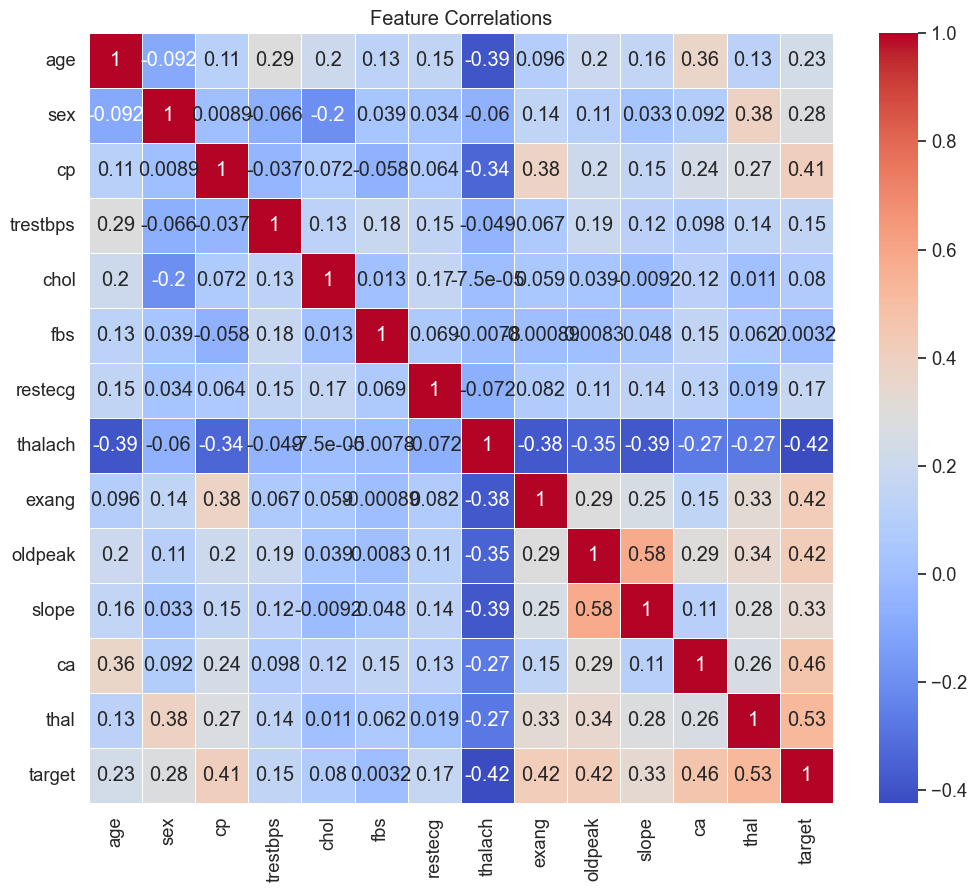

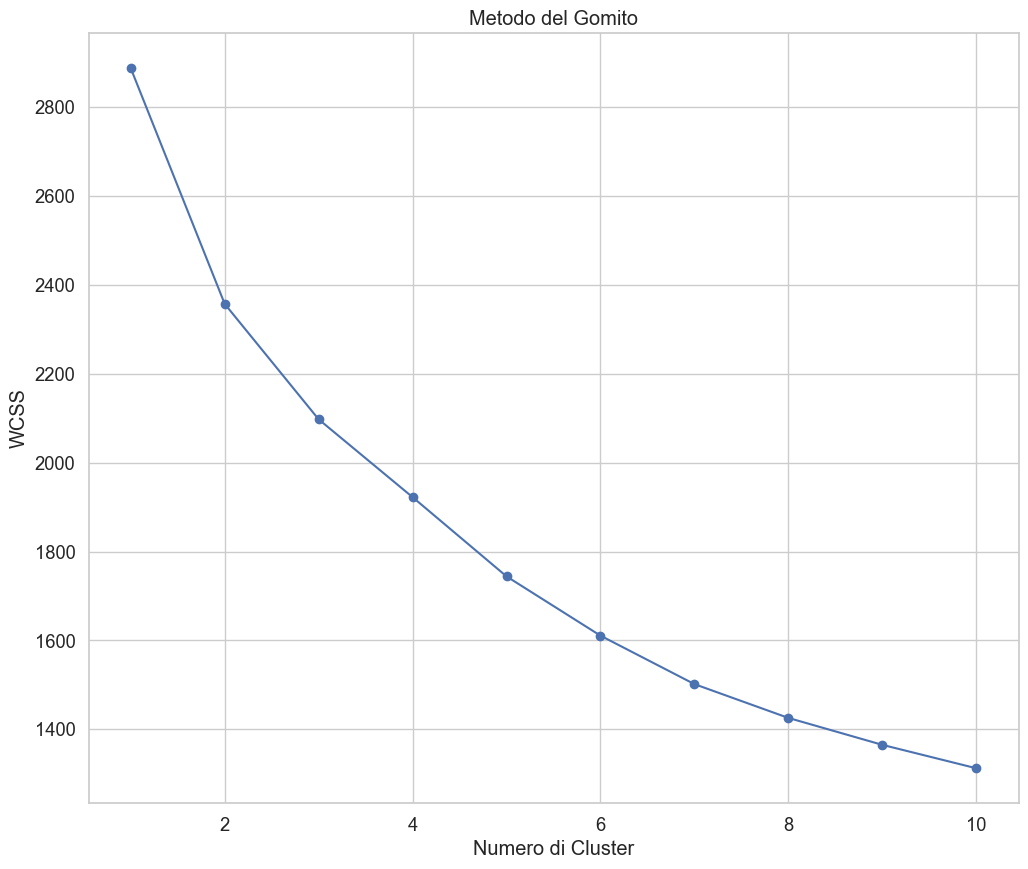


Random Forest Baseline:
Cross-validation scores: [0.83333333 0.8        0.72881356 0.79661017 0.79661017]
Mean CV score (Accuracy): 0.791 (+/- 0.068)
Test Accuracy: 0.817


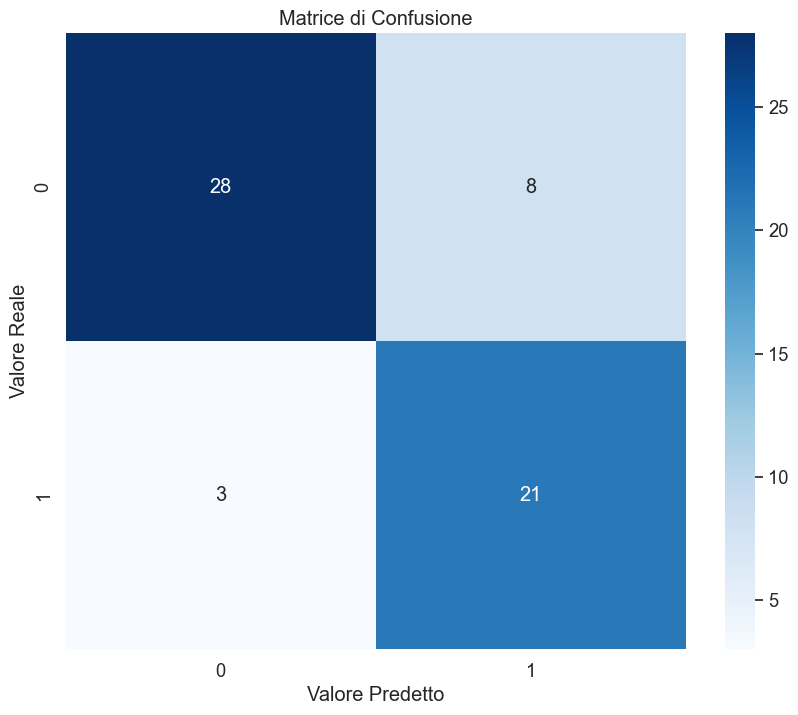

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84        36
           1       0.72      0.88      0.79        24

    accuracy                           0.82        60
   macro avg       0.81      0.83      0.81        60
weighted avg       0.83      0.82      0.82        60



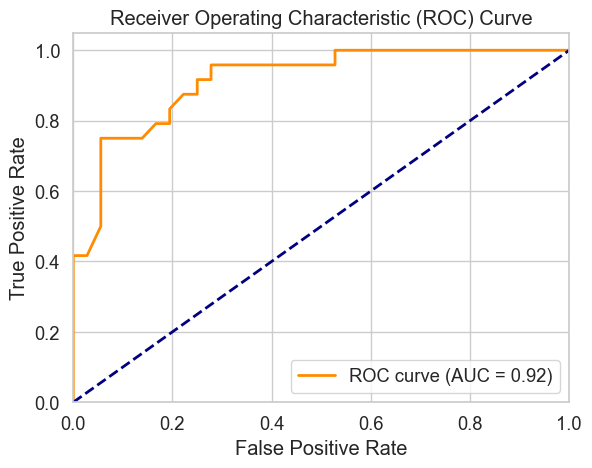


Random Forest Optimized:
Best parameters: {'model__max_depth': 10, 'model__n_estimators': 200}
Best cross-validation score: 0.798
Cross-validation scores: [0.88333333 0.8        0.71186441 0.79661017 0.79661017]
Mean CV score (Accuracy): 0.798 (+/- 0.108)
Test Accuracy: 0.800


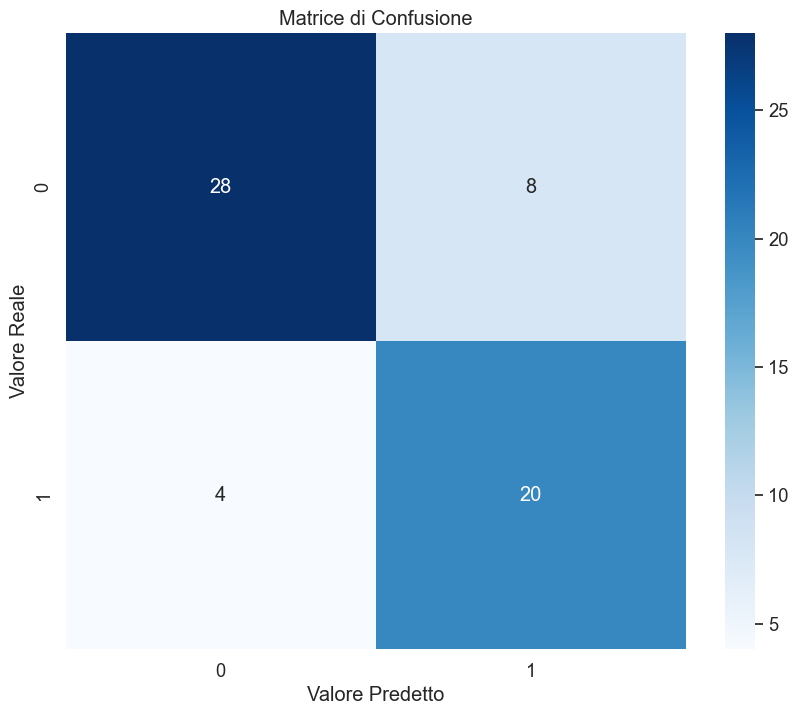

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        36
           1       0.71      0.83      0.77        24

    accuracy                           0.80        60
   macro avg       0.79      0.81      0.80        60
weighted avg       0.81      0.80      0.80        60



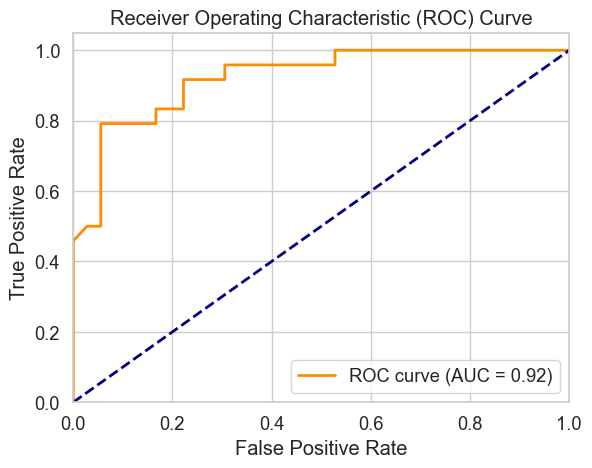

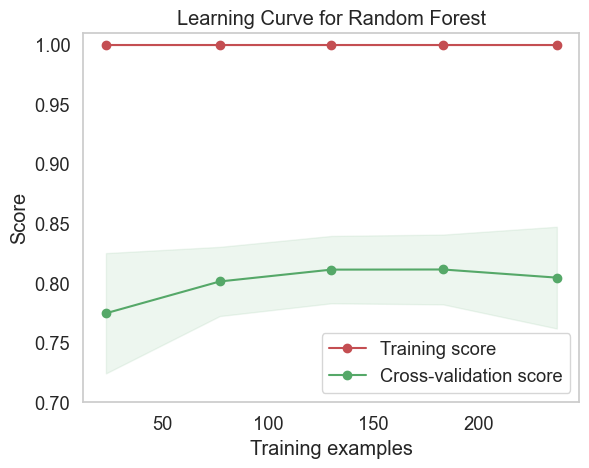


k-NN Baseline:
Cross-validation scores: [0.88333333 0.8        0.72881356 0.77966102 0.81355932]
Mean CV score (Accuracy): 0.801 (+/- 0.100)
Test Accuracy: 0.833


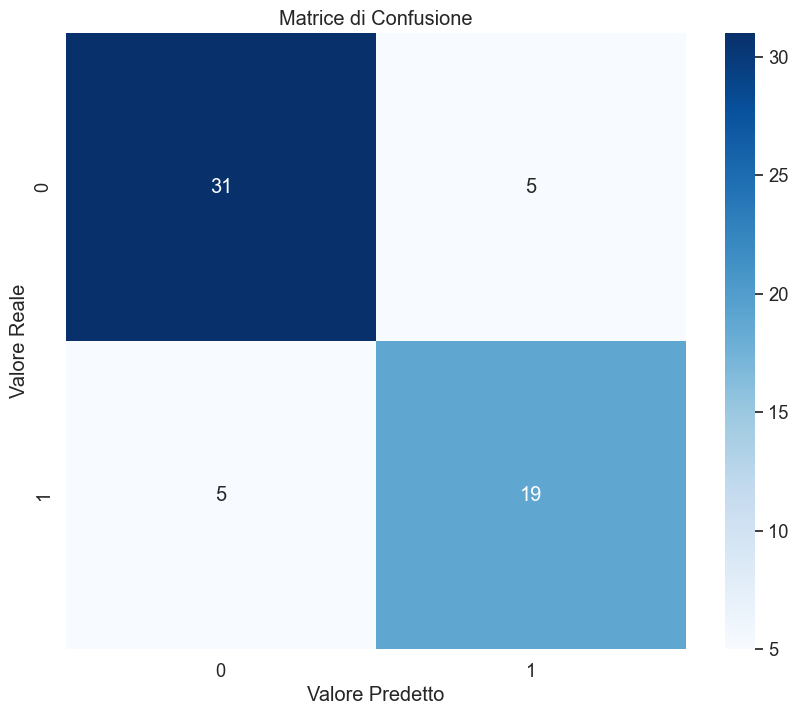

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        36
           1       0.79      0.79      0.79        24

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60



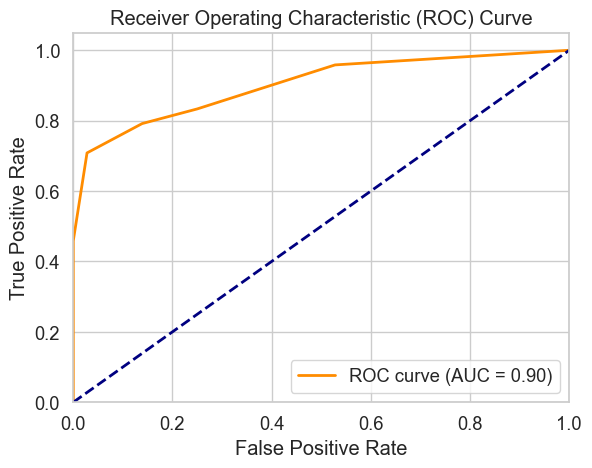


k-NN Optimized:
Best parameters: {'model__n_neighbors': 3, 'model__weights': 'uniform'}
Best cross-validation score: 0.804
Cross-validation scores: [0.85       0.83333333 0.76271186 0.77966102 0.79661017]
Mean CV score (Accuracy): 0.804 (+/- 0.065)
Test Accuracy: 0.833


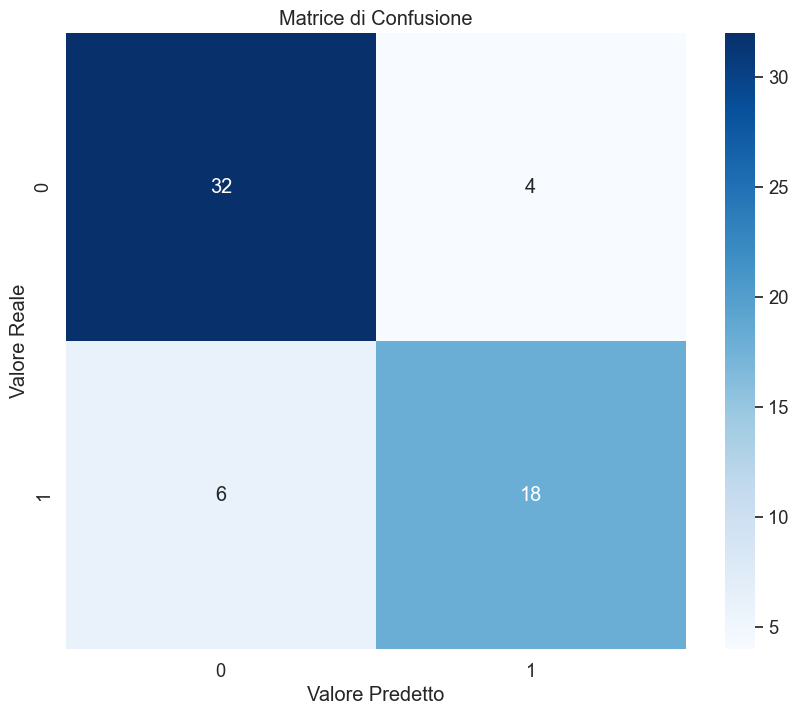

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        36
           1       0.82      0.75      0.78        24

    accuracy                           0.83        60
   macro avg       0.83      0.82      0.82        60
weighted avg       0.83      0.83      0.83        60



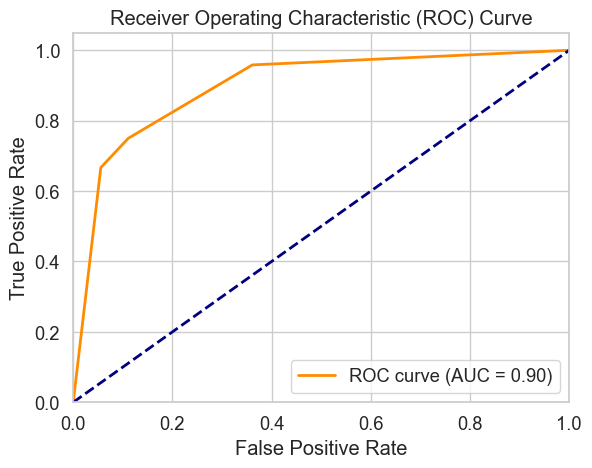

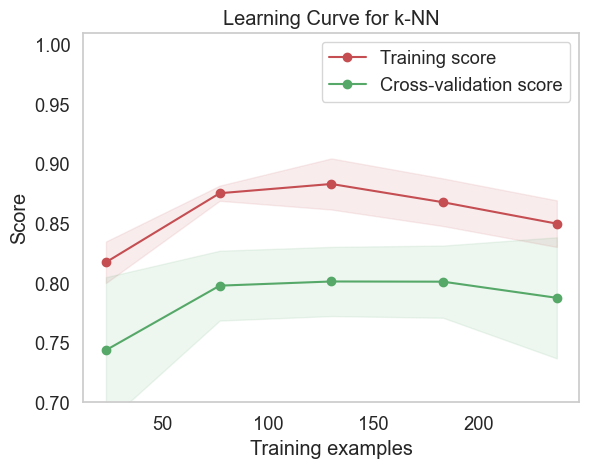


XGBoost Baseline:
Cross-validation scores: [0.83333333 0.78333333 0.71186441 0.77966102 0.76271186]
Mean CV score (Accuracy): 0.774 (+/- 0.078)
Test Accuracy: 0.800


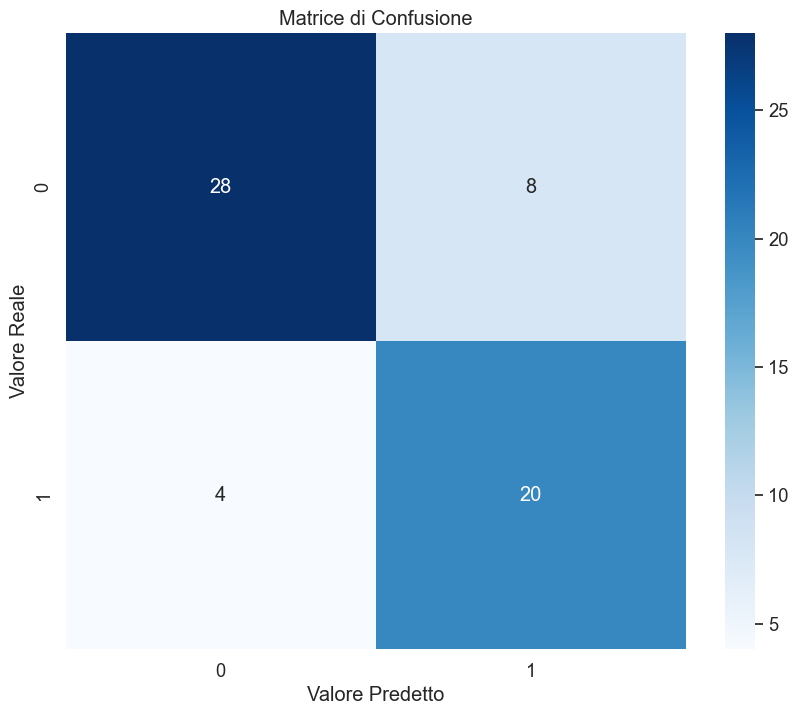

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        36
           1       0.71      0.83      0.77        24

    accuracy                           0.80        60
   macro avg       0.79      0.81      0.80        60
weighted avg       0.81      0.80      0.80        60



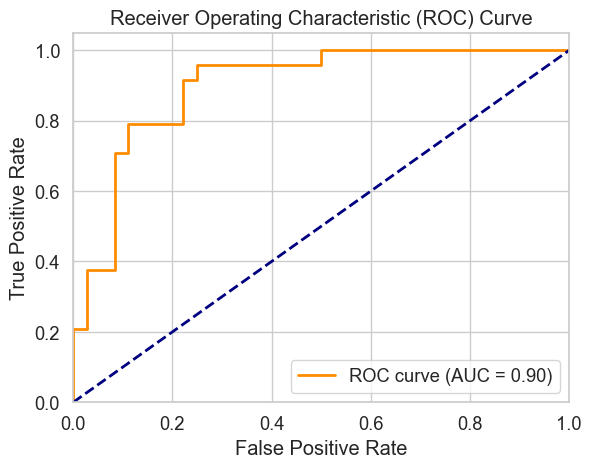


XGBoost Optimized:
Best parameters: {'model__max_depth': 5, 'model__n_estimators': 100}
Best cross-validation score: 0.788
Cross-validation scores: [0.85       0.83333333 0.72881356 0.76271186 0.76271186]
Mean CV score (Accuracy): 0.788 (+/- 0.092)
Test Accuracy: 0.800


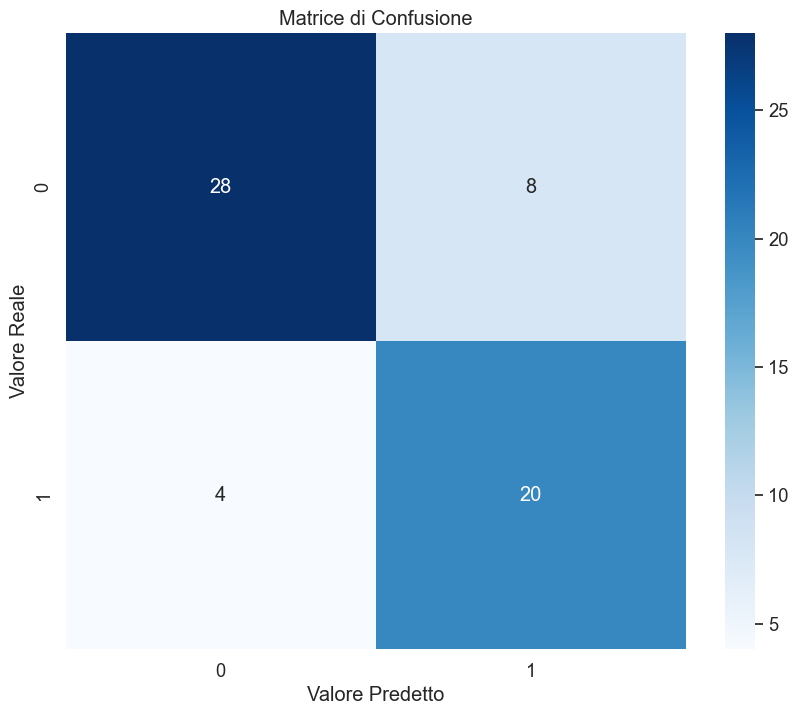

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        36
           1       0.71      0.83      0.77        24

    accuracy                           0.80        60
   macro avg       0.79      0.81      0.80        60
weighted avg       0.81      0.80      0.80        60



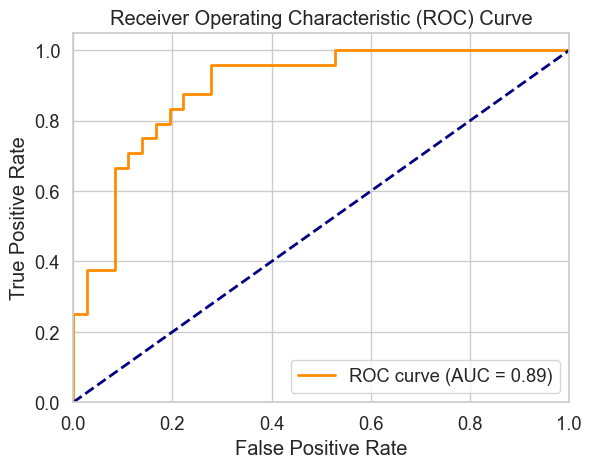

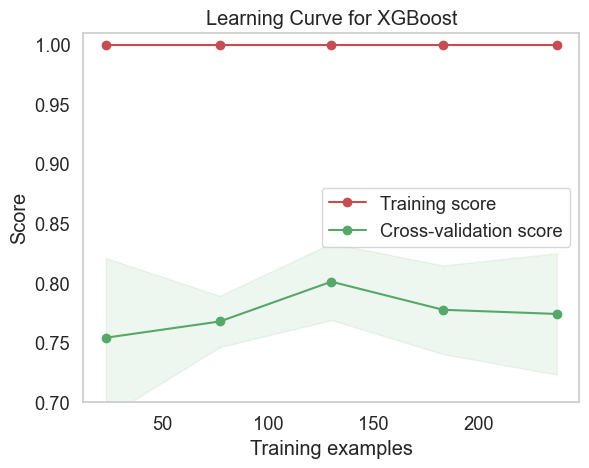


Decision Tree Baseline:
Cross-validation scores: [0.8        0.78333333 0.72881356 0.72881356 0.71186441]
Mean CV score (Accuracy): 0.751 (+/- 0.069)
Test Accuracy: 0.717


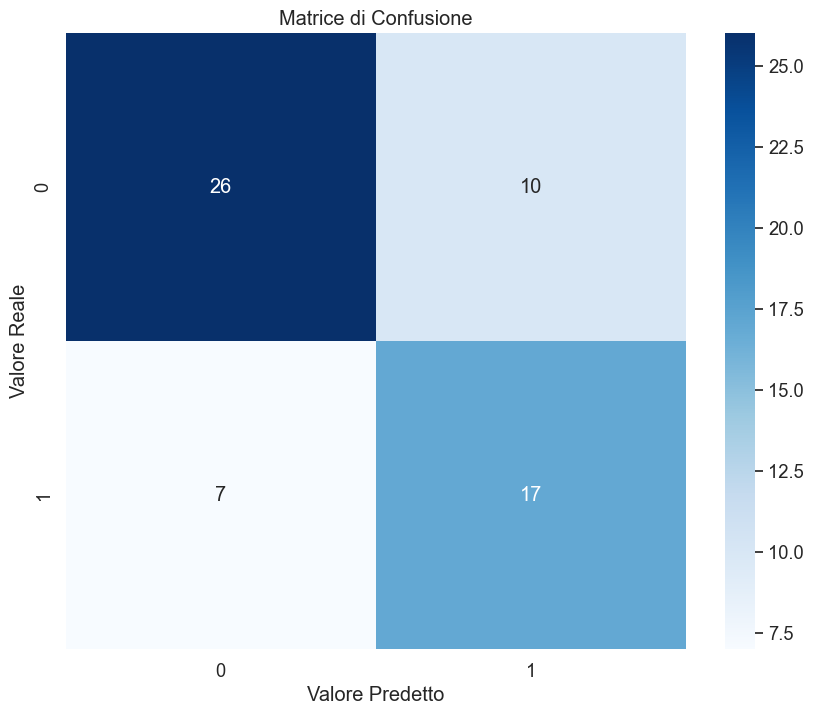

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.72      0.75        36
           1       0.63      0.71      0.67        24

    accuracy                           0.72        60
   macro avg       0.71      0.72      0.71        60
weighted avg       0.72      0.72      0.72        60



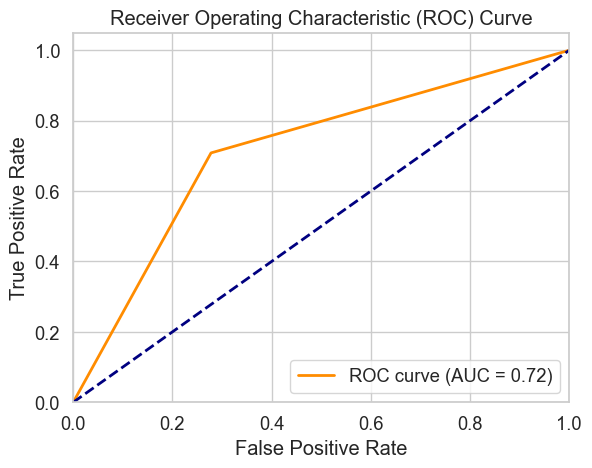


Decision Tree Optimized:
Best parameters: {'model__max_depth': None, 'model__min_samples_split': 10}
Best cross-validation score: 0.771
Cross-validation scores: [0.83333333 0.8        0.71186441 0.79661017 0.71186441]
Mean CV score (Accuracy): 0.771 (+/- 0.100)
Test Accuracy: 0.783


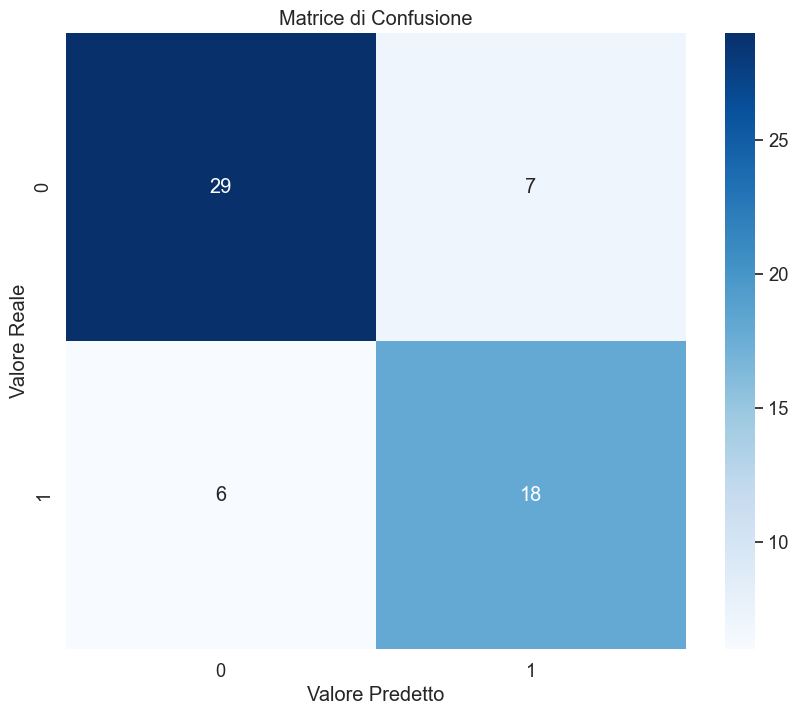

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        36
           1       0.72      0.75      0.73        24

    accuracy                           0.78        60
   macro avg       0.77      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60



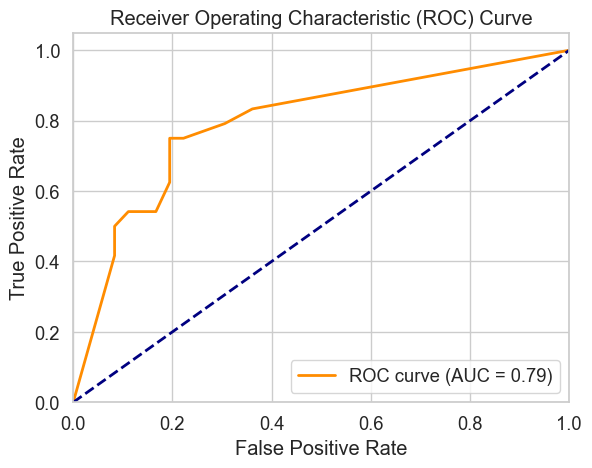

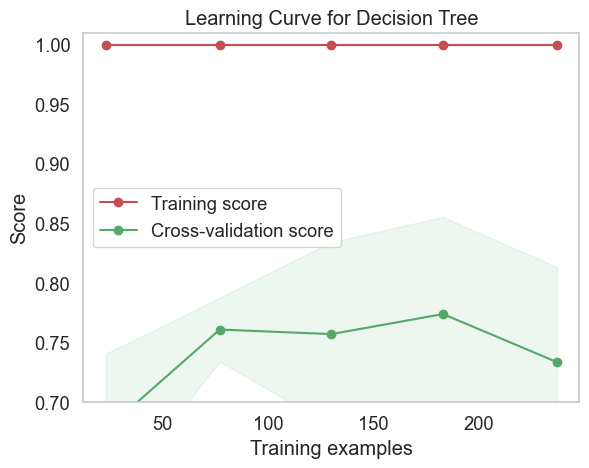


Naive Bayes Baseline:
Cross-validation scores: [0.88333333 0.78333333 0.77966102 0.79661017 0.79661017]
Mean CV score (Accuracy): 0.808 (+/- 0.077)
Test Accuracy: 0.867


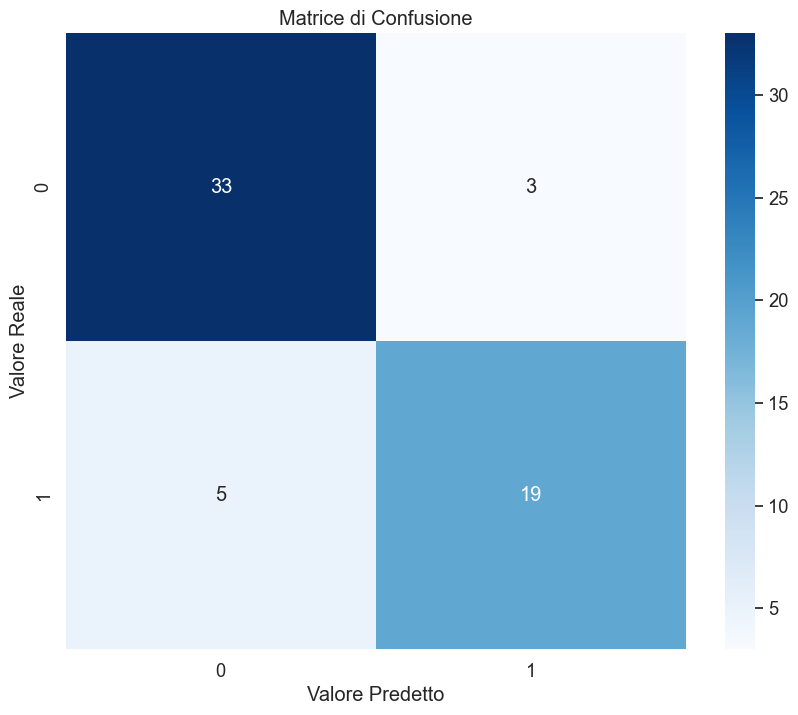

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        36
           1       0.86      0.79      0.83        24

    accuracy                           0.87        60
   macro avg       0.87      0.85      0.86        60
weighted avg       0.87      0.87      0.87        60



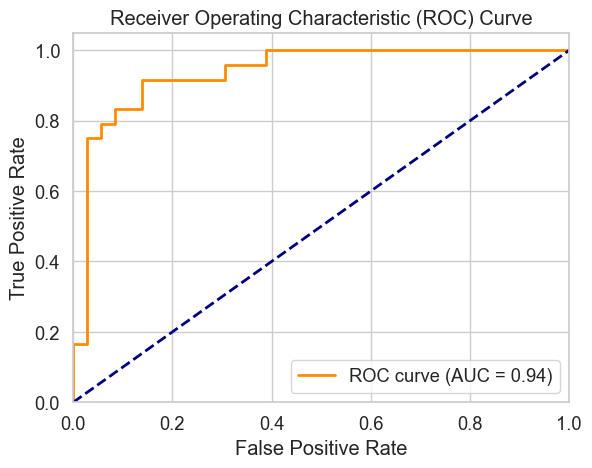


Naive Bayes non richiede ottimizzazione degli iperparametri.


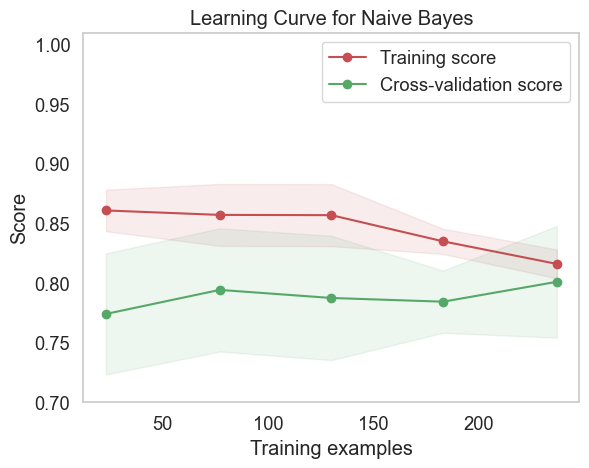


Random Forest with SMOTE:
Cross-validation scores: [0.88333333 0.81666667 0.72881356 0.79661017 0.81355932]
Mean CV score (Accuracy): 0.808 (+/- 0.099)
Test Accuracy: 0.800


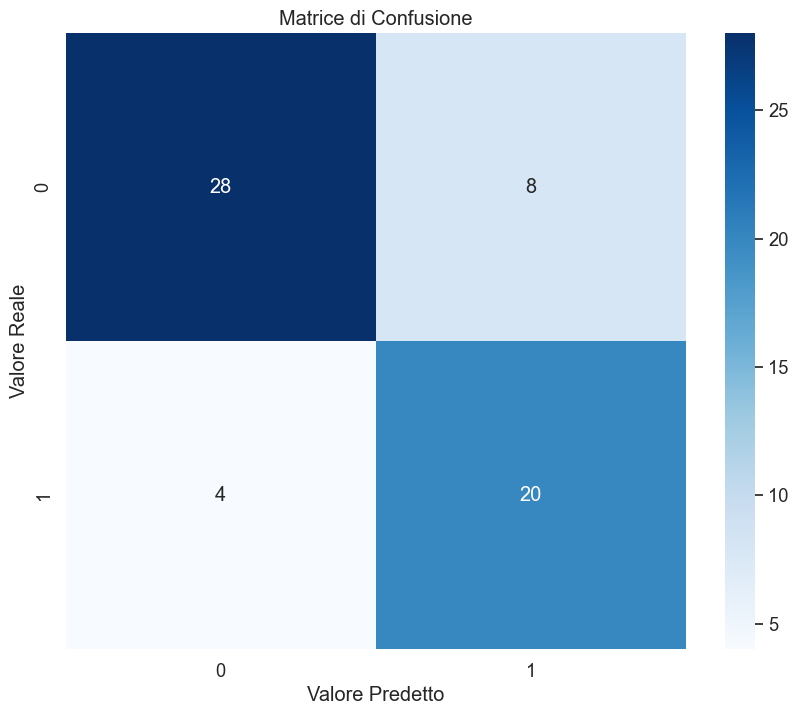

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        36
           1       0.71      0.83      0.77        24

    accuracy                           0.80        60
   macro avg       0.79      0.81      0.80        60
weighted avg       0.81      0.80      0.80        60



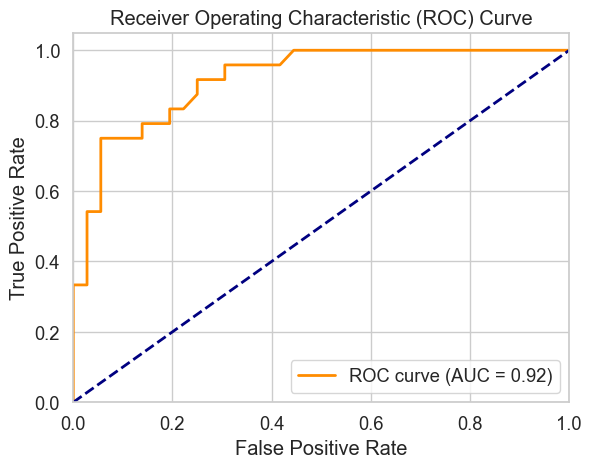


Dati per il grafico di confronto SMOTE:
Prima di SMOTE: [160, 137]
Dopo SMOTE: [160, 160]

Ensemble Model:
Cross-validation scores: [0.88333333 0.8        0.72881356 0.77966102 0.83050847]
Mean CV score (Accuracy): 0.804 (+/- 0.103)
Test Accuracy: 0.817


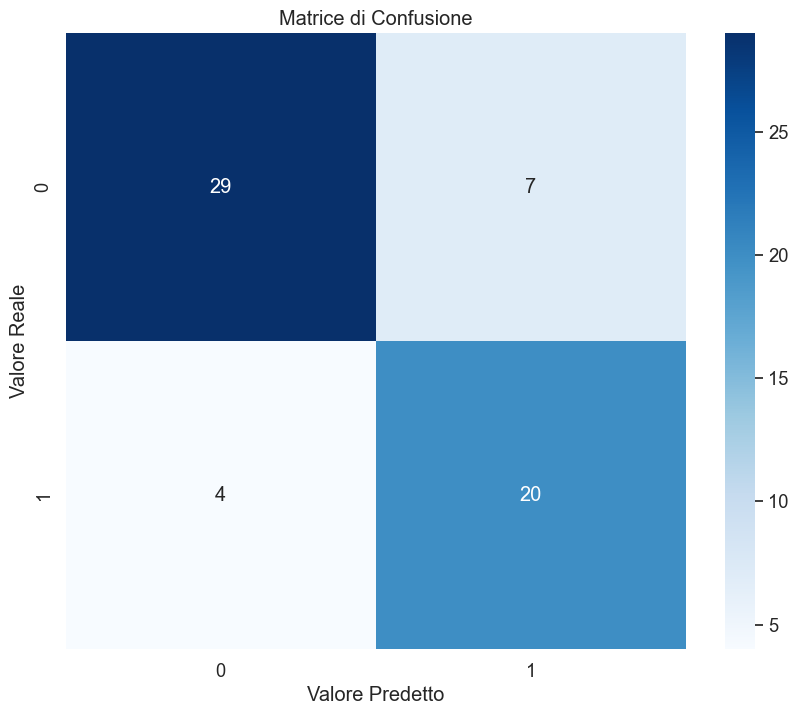

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        36
           1       0.74      0.83      0.78        24

    accuracy                           0.82        60
   macro avg       0.81      0.82      0.81        60
weighted avg       0.82      0.82      0.82        60



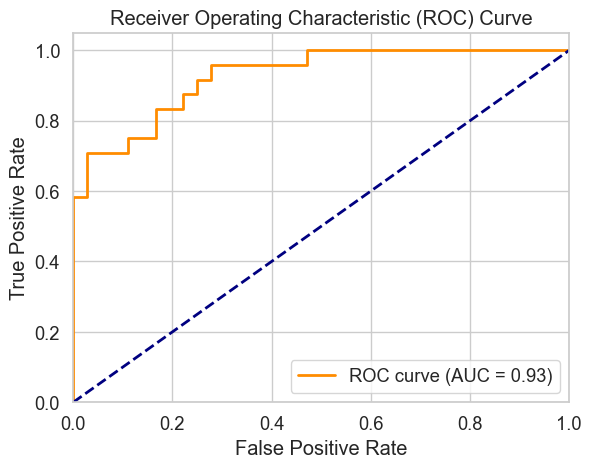

Probabilità di malattia cardiaca dato l'evidence:
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.5000 |
+-----------+---------------+
| target(1) |        0.5000 |
+-----------+---------------+


In [22]:
# Funzione principale

def main():
    """
    Funzione principale del progetto.
    :return:
    """
    print("Analisi delle malattie cardiache")

   # Configura l'ambiente
    configure_environment()

    # Carica e preprocessa i dati
    df = load_and_preprocess_data(DATA_FILE_PATH)

    # Visualizza le correlazioni
    visualize_correlations(df)

    # Esegui il feature engineering
    X, y = perform_feature_engineering(df)

    # Visualizza la distribuzione delle classi
    plot_class_distribution(y)
    plot_class_distribution_bar(y)

    # Metodo del Gomito per K-means
    plot_elbow_curve(X)

    # Valuta i modelli di base
    evaluate_models(X, y)

    # Gestione dello sbilanciamento
    handle_imbalance(X, y)

    # Crea e valuta il modello ensemble
    create_ensemble_model(X, y)

    # Esegui l'analisi con la rete bayesiana
    bayesian_network_analysis(df)

    # Esegui il clustering
    X_scaled = StandardScaler().fit_transform(X)
    perform_clustering(X_scaled)

if __name__ == "__main__":
    main()
